<a href="https://colab.research.google.com/github/ammarshibani/data-analysis-colab/blob/main/Financial_Investment_Advisor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
import skfuzzy.control as ctrl

def import_and_load_data(file_path):

    df = pd.read_csv(file_path)
    return df

file_path = "stock_data.csv"
raw_data = import_and_load_data(file_path)

print("----- Raw Data (First 5 Rows) -----")
print(raw_data.head())


----- Raw Data (First 5 Rows) -----
           dt    vix       sp500  sp500_volume     djia  djia_volume  \
0  1990-01-03  18.19  358.760010   192330000.0  2809.73        23.62   
1  1990-01-04  19.22  355.670013   177000000.0  2796.08        24.37   
2  1990-01-05  20.11  352.200012   158530000.0  2773.25        20.29   
3  1990-01-08  20.26  353.790009   140110000.0  2794.37        16.61   
4  1990-01-09  22.20  349.619995   155210000.0  2766.00        15.80   

           hsi       ads  us3m  joblessness         epu        GPRD  \
0  2858.699951 -0.229917  7.89            3  100.359178   75.408051   
1  2868.000000 -0.246065  7.84            3  100.359178   56.085804   
2  2839.899902 -0.260393  7.79            3  100.359178   63.847675   
3  2816.000000 -0.291750  7.79            3  100.359178  102.841156   
4  2822.000000 -0.297326  7.80            3  100.359178  138.435669   

     prev_day  
0  359.690002  
1  358.760010  
2  355.670013  
3  352.200012  
4  353.790009  


In [ ]:
def clean_and_preprocess_data(df):

    df['dt'] = pd.to_datetime(df['dt'], errors='coerce')
    df.dropna(subset=['dt'], inplace=True)

    df.drop_duplicates(subset=['dt'], keep='last', inplace=True)
    df.sort_values('dt', inplace=True)
    df.reset_index(drop=True, inplace=True)

    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_cols] = df[numeric_cols].interpolate(method='linear')
    df[numeric_cols] = df[numeric_cols].fillna(method='bfill')

    return df


In [ ]:
def generate_fuzzy_features(df, n_clusters=3):

    df['SMA_20'] = df['sp500'].rolling(window=20).mean()
    df['volatility_20'] = df['sp500'].rolling(window=20).std()

    df = df.dropna(subset=['SMA_20', 'volatility_20']).copy()

    features = np.vstack((df['SMA_20'].values, df['volatility_20'].values))

    cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(
        data=features, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None
    )

    for i in range(n_clusters):
        df[f'fuzzy_membership_cluster_{i}'] = u[i, :]

    return df, cntr, u, fpc

# Generate fuzzy features using the cleaned data
fuzzy_data, centers, membership, fpc = generate_fuzzy_features(cleaned_data)
print("\n----- Fuzzy Data (First 5 Rows) -----")
print(fuzzy_data.head())
print("\nFuzzy Partition Coefficient (FPC):", fpc)



----- Fuzzy Data (First 5 Rows) -----
           dt    vix       sp500  sp500_volume     djia  djia_volume  \
19 1990-01-30  27.25  322.980011   186030000.0  2543.24        24.91   
20 1990-01-31  25.36  329.079987   189660000.0  2590.54        22.51   
21 1990-02-01  24.87  328.790009   154580000.0  2586.26        19.80   
22 1990-02-02  24.32  330.920013   164400000.0  2602.70        18.70   
23 1990-02-05  24.54  331.850006   130950000.0  2622.52        13.65   

            hsi       ads  us3m  joblessness         epu        GPRD  \
19  2760.800049  0.070304  8.00            3  100.359178   83.924965   
20  2751.600098  0.107416  8.00            3  100.359178  128.320419   
21  2738.199951  0.147694  8.02            3   89.590954   77.207466   
22  2736.600098  0.187236  8.07            3   89.590954  104.904701   
23  2756.600098  0.300568  8.08            3   89.590954  115.420479   

      prev_day      SMA_20  volatility_20  fuzzy_membership_cluster_0  \
19  325.200012  339.53

In [ ]:
sma['low'] = fuzz.trimf(sma.universe, [sma_range[0], sma_range[0], (sma_min+sma_max)/2])
sma['medium'] = fuzz.trimf(sma.universe, [sma_min, (sma_min+sma_max)/2, sma_max])
sma['high'] = fuzz.trimf(sma.universe, [(sma_min+sma_max)/2, sma_range[-1], sma_range[-1]])

volatility['low'] = fuzz.trimf(volatility.universe, [vol_range[0], vol_range[0], (vol_min+vol_max)/2])
volatility['medium'] = fuzz.trimf(volatility.universe, [vol_min, (vol_min+vol_max)/2, vol_max])
volatility['high'] = fuzz.trimf(volatility.universe, [(vol_min+vol_max)/2, vol_range[-1], vol_range[-1]])

recommendation['conservative'] = fuzz.trimf(recommendation.universe, [0, 0, 4])
recommendation['balanced'] = fuzz.trimf(recommendation.universe, [3, 5, 7])
recommendation['aggressive'] = fuzz.trimf(recommendation.universe, [6, 10, 10])


In [ ]:
rule1 = ctrl.Rule((volatility['low'] & sma['high']), recommendation['conservative'])
rule2 = ctrl.Rule((volatility['high'] & sma['low']), recommendation['aggressive'])
rule3 = ctrl.Rule((volatility['medium'] | sma['medium']), recommendation['balanced'])
rule4 = ctrl.Rule((volatility['low'] & sma['medium']), recommendation['conservative'])
rule5 = ctrl.Rule((volatility['high'] & sma['high']), recommendation['aggressive'])


In [ ]:
investment_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
investment_simulation = ctrl.ControlSystemSimulation(investment_ctrl)

sample = fuzzy_data.iloc[50]
investment_simulation.input['sma'] = sample['SMA_20']
investment_simulation.input['volatility'] = sample['volatility_20']
investment_simulation.compute()
rec_score = investment_simulation.output['recommendation']

print("\n----- Fuzzy Rule-Based Inference for a Sample -----")
print(f"Sample SMA_20: {sample['SMA_20']:.2f}, Sample Volatility_20: {sample['volatility_20']:.2f}")
print(f"Fuzzy Recommendation Score: {rec_score:.2f}")

if rec_score <= 3:
    recommendation_label = 'Conservative'
elif rec_score >= 7:
    recommendation_label = 'Aggressive'
else:
    recommendation_label = 'Balanced'

print(f"Investment Recommendation: {recommendation_label}")



----- Fuzzy Rule-Based Inference for a Sample -----
Sample SMA_20: 340.46, Sample Volatility_20: 2.10
Fuzzy Recommendation Score: 3.51
Investment Recommendation: Balanced


In [ ]:
def setup_fuzzy_system(df):
    sma_min, sma_max = df['SMA_20'].min(), df['SMA_20'].max()
    vol_min, vol_max = df['volatility_20'].min(), df['volatility_20'].max()
    sma_range = np.linspace(sma_min - 0.05*(sma_max - sma_min), sma_max + 0.05*(sma_max - sma_min), 100)
    vol_range = np.linspace(vol_min - 0.05*(vol_max - vol_min), vol_max + 0.05*(vol_max - vol_min), 100)
    rec_range = np.linspace(0, 10, 100)

    sma = ctrl.Antecedent(sma_range, 'sma')
    volatility = ctrl.Antecedent(vol_range, 'volatility')
    recommendation = ctrl.Consequent(rec_range, 'recommendation')

    sma['low'] = fuzz.trimf(sma.universe, [sma_range[0], sma_range[0], (sma_min+sma_max)/2])
    sma['medium'] = fuzz.trimf(sma.universe, [sma_min, (sma_min+sma_max)/2, sma_max])
    sma['high'] = fuzz.trimf(sma.universe, [(sma_min+sma_max)/2, sma_range[-1], sma_range[-1]])

    volatility['low'] = fuzz.trimf(volatility.universe, [vol_range[0], vol_range[0], (vol_min+vol_max)/2])
    volatility['medium'] = fuzz.trimf(volatility.universe, [vol_min, (vol_min+vol_max)/2, vol_max])
    volatility['high'] = fuzz.trimf(volatility.universe, [(vol_min+vol_max)/2, vol_range[-1], vol_range[-1]])

    recommendation['conservative'] = fuzz.trimf(recommendation.universe, [0, 0, 4])
    recommendation['balanced'] = fuzz.trimf(recommendation.universe, [3, 5, 7])
    recommendation['aggressive'] = fuzz.trimf(recommendation.universe, [6, 10, 10])

    rule1 = ctrl.Rule((volatility['low'] & sma['high']), recommendation['conservative'])
    rule2 = ctrl.Rule((volatility['high'] & sma['low']), recommendation['aggressive'])
    rule3 = ctrl.Rule((volatility['medium'] | sma['medium']), recommendation['balanced'])
    rule4 = ctrl.Rule((volatility['low'] & sma['medium']), recommendation['conservative'])
    rule5 = ctrl.Rule((volatility['high'] & sma['high']), recommendation['aggressive'])

    investment_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
    investment_simulation = ctrl.ControlSystemSimulation(investment_ctrl)

    return sma, volatility, recommendation, investment_simulation, sma_range, vol_range, rec_range


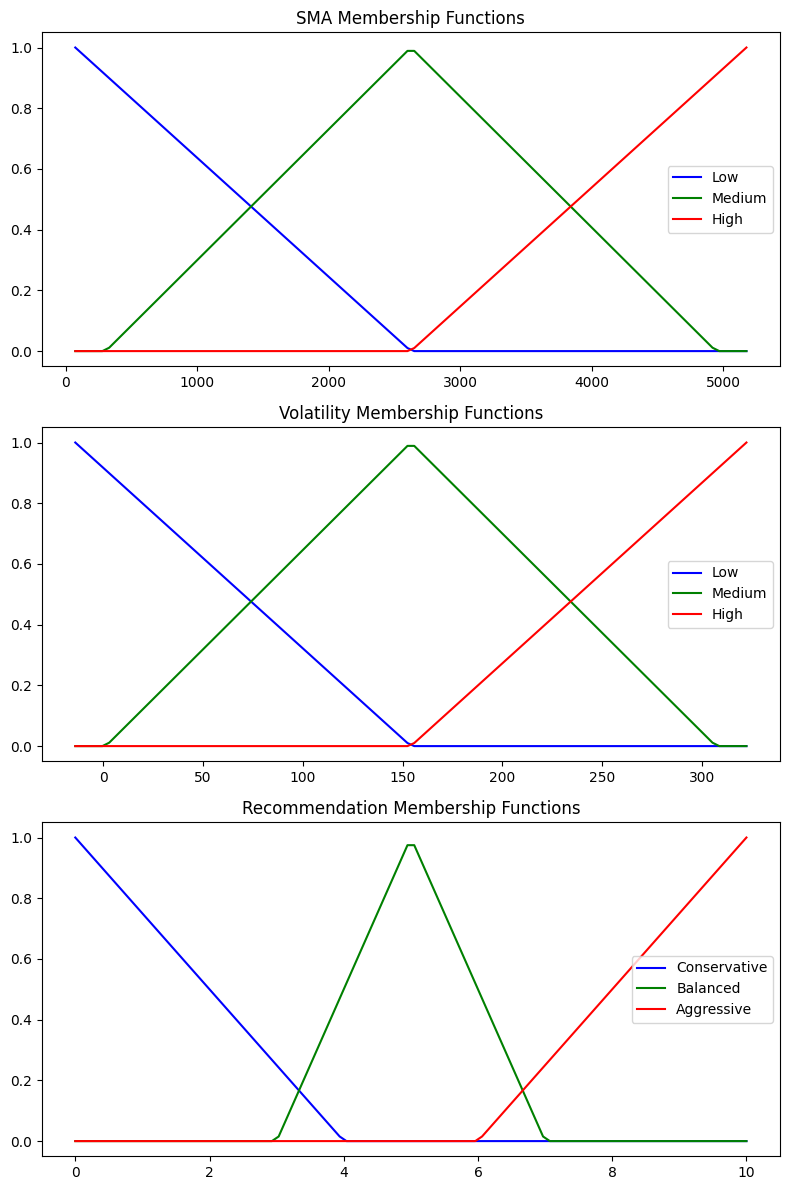

In [ ]:
sma_var, vol_var, rec_var, investment_simulation, sma_range, vol_range, rec_range = setup_fuzzy_system(fuzzy_data)

def plot_membership_functions(sma, volatility, recommendation):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))

    axes[0].plot(sma.universe, sma['low'].mf, 'b', linewidth=1.5, label='Low')
    axes[0].plot(sma.universe, sma['medium'].mf, 'g', linewidth=1.5, label='Medium')
    axes[0].plot(sma.universe, sma['high'].mf, 'r', linewidth=1.5, label='High')
    axes[0].set_title('SMA Membership Functions')
    axes[0].legend()

    axes[1].plot(volatility.universe, volatility['low'].mf, 'b', linewidth=1.5, label='Low')
    axes[1].plot(volatility.universe, volatility['medium'].mf, 'g', linewidth=1.5, label='Medium')
    axes[1].plot(volatility.universe, volatility['high'].mf, 'r', linewidth=1.5, label='High')
    axes[1].set_title('Volatility Membership Functions')
    axes[1].legend()

    axes[2].plot(recommendation.universe, recommendation['conservative'].mf, 'b', label='Conservative')
    axes[2].plot(recommendation.universe, recommendation['balanced'].mf, 'g', label='Balanced')
    axes[2].plot(recommendation.universe, recommendation['aggressive'].mf, 'r', label='Aggressive')
    axes[2].set_title('Recommendation Membership Functions')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

plot_membership_functions(sma_var, vol_var, rec_var)


In [ ]:
def evaluate_fuzzy_system(df, investment_simulation, n_samples=50):
    sample_indices = np.linspace(0, len(df)-1, n_samples, dtype=int)
    recommendation_scores, sma_values, volatility_values = [], [], []

    for idx in sample_indices:
        sample = df.iloc[idx]
        investment_simulation.input['sma'] = sample['SMA_20']
        investment_simulation.input['volatility'] = sample['volatility_20']
        investment_simulation.compute()
        recommendation_scores.append(investment_simulation.output['recommendation'])
        sma_values.append(sample['SMA_20'])
        volatility_values.append(sample['volatility_20'])

    results_df = pd.DataFrame({
        'SMA_20': sma_values,
        'Volatility_20': volatility_values,
        'Recommendation_Score': recommendation_scores,
        'Sample_Index': sample_indices
    })
    return results_df

results = evaluate_fuzzy_system(fuzzy_data, investment_simulation, n_samples=50)


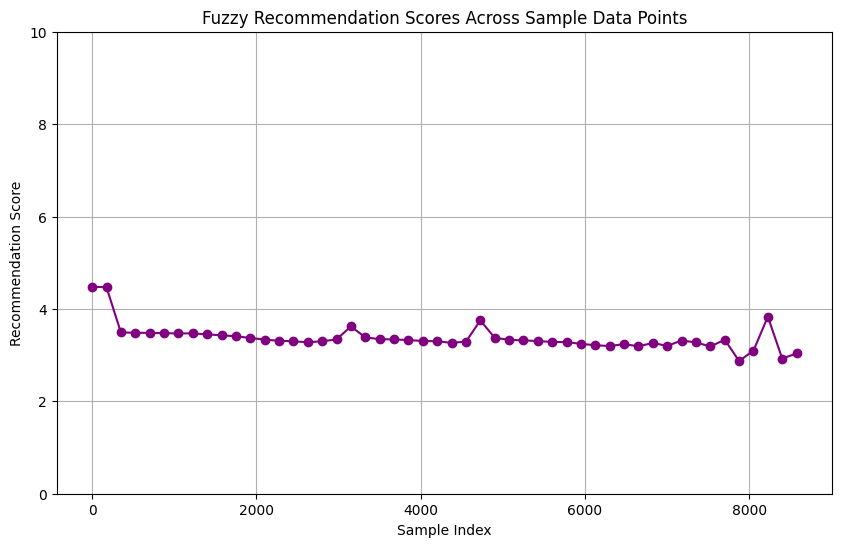

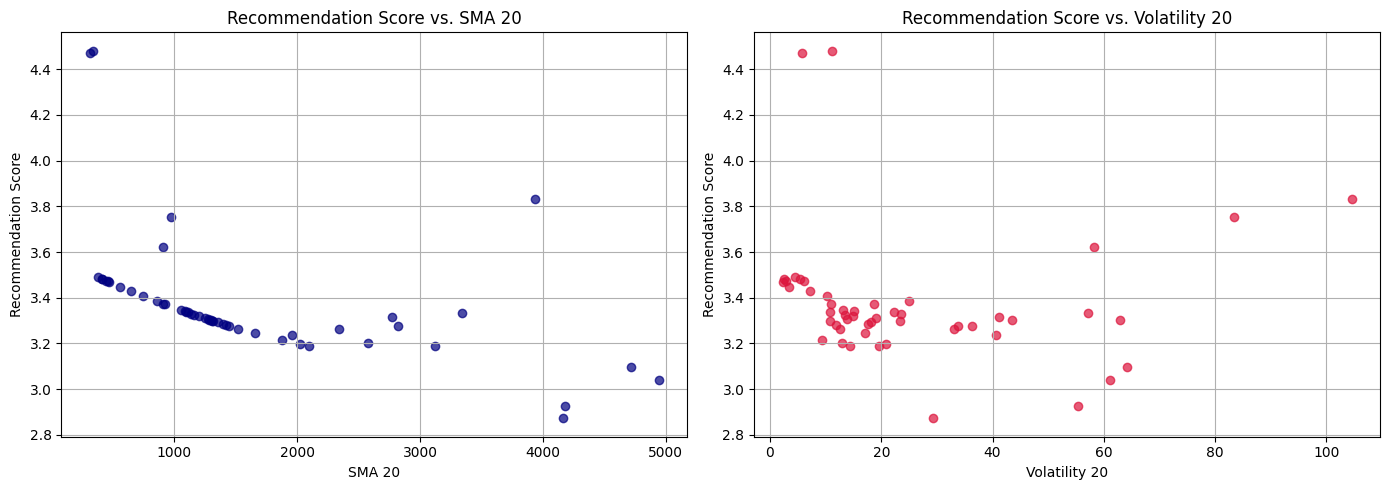

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(results['Sample_Index'], results['Recommendation_Score'], marker='o', linestyle='-', color='purple')
plt.title('Fuzzy Recommendation Scores Across Sample Data Points')
plt.xlabel('Sample Index')
plt.ylabel('Recommendation Score')
plt.grid(True)
plt.ylim(0, 10)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].scatter(results['SMA_20'], results['Recommendation_Score'], c='navy', alpha=0.7)
ax[0].set_title('Recommendation Score vs. SMA 20')
ax[0].set_xlabel('SMA 20')
ax[0].set_ylabel('Recommendation Score')
ax[0].grid(True)

ax[1].scatter(results['Volatility_20'], results['Recommendation_Score'], c='crimson', alpha=0.7)
ax[1].set_title('Recommendation Score vs. Volatility 20')
ax[1].set_xlabel('Volatility 20')
ax[1].set_ylabel('Recommendation Score')
ax[1].grid(True)

plt.tight_layout()
plt.show()
